In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *

In [2]:
df = pd.read_csv('testSet.txt', sep = '\t', names = ['x', 'y', 'label'])

In [3]:
dataMat = (df[['x', 'y']].values)
labelMat = (df['label'].values)

non kernel function

In [4]:
def selectJrand(i,m):
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(random.uniform(0,m))
    return j

def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

class optStructK:
    def __init__(self,dataMatIn, classLabels, C, toler):  # Initialize the structure with the parameters 
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2))) #first column is valid flag
        
def calcEkK(oS, k):
    fXk = float(multiply(oS.alphas,oS.labelMat).T*(oS.X*oS.X[k,:].T)) + oS.b
    Ek = fXk - float(oS.labelMat[k])
    return Ek
        
def selectJK(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: continue #don't calc for i, waste of time
            Ek = calcEkK(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:   #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEkK(oS, j)
    return j, Ej

def updateEkK(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEkK(oS, k)
    oS.eCache[k] = [1,Ek]
        
def innerLK(i, oS):
    Ei = calcEkK(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        j,Ej = selectJK(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: print ("L==H"); return 0
        eta = 2.0 * oS.X[i,:]*oS.X[j,:].T - oS.X[i,:]*oS.X[i,:].T - oS.X[j,:]*oS.X[j,:].T
        if eta >= 0: print ("eta>=0"); return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEkK(oS, j) #added this for the Ecache
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): print ("j not moving enough"); return 0
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])#update i by the same amount as j
        updateEkK(oS, i) #added this for the Ecache                    #the update is in the oppostie direction
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[i,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.X[i,:]*oS.X[j,:].T - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.X[j,:]*oS.X[j,:].T
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

def smoPK(dataMatIn, classLabels, C, toler, maxIter):    #full Platt SMO
    oS = optStructK(mat(dataMatIn),mat(classLabels).transpose(),C,toler)
    iter = 0
    entireSet = True; alphaPairsChanged = 0
    while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerLK(i,oS)
                print ("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerLK(i,oS)
                print ("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
            iter += 1
        if entireSet: entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0): entireSet = True  
        print("iteration number: %d" % iter)
    return oS.b,oS.alphas

In [5]:
b, alpha = smoPK(dataMat, labelMat, 0.6, 0.001, 40)

L==H
fullSet, iter: 0 i:0, pairs changed 0
L==H
fullSet, iter: 0 i:1, pairs changed 0
fullSet, iter: 0 i:2, pairs changed 1
L==H
fullSet, iter: 0 i:3, pairs changed 1
fullSet, iter: 0 i:4, pairs changed 2
fullSet, iter: 0 i:5, pairs changed 2
fullSet, iter: 0 i:6, pairs changed 2
j not moving enough
fullSet, iter: 0 i:7, pairs changed 2
L==H
fullSet, iter: 0 i:8, pairs changed 2
fullSet, iter: 0 i:9, pairs changed 2
L==H
fullSet, iter: 0 i:10, pairs changed 2
L==H
fullSet, iter: 0 i:11, pairs changed 2
L==H
fullSet, iter: 0 i:12, pairs changed 2
fullSet, iter: 0 i:13, pairs changed 2
L==H
fullSet, iter: 0 i:14, pairs changed 2
fullSet, iter: 0 i:15, pairs changed 2
fullSet, iter: 0 i:16, pairs changed 2
L==H
fullSet, iter: 0 i:17, pairs changed 2
fullSet, iter: 0 i:18, pairs changed 3
fullSet, iter: 0 i:19, pairs changed 3
fullSet, iter: 0 i:20, pairs changed 3
fullSet, iter: 0 i:21, pairs changed 3
j not moving enough
fullSet, iter: 0 i:22, pairs changed 3
L==H
fullSet, iter: 0 i:23, 

In [6]:
def floatrange(start,stop,steps):
    ''' Computes a range of floating value.
        
        Input:
            start (float)  : Start value.
            end   (float)  : End value
            steps (integer): Number of values
        
        Output:
            A list of floats
    '''
    return [start+float(i)*(stop-start)/(float(steps)-1) for i in range(steps)]


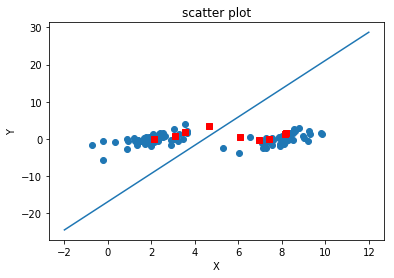

In [7]:
sv = []
for i in range(len(alpha)):
    if alpha[i] > 0:
#             svx.append(data[i][0])
#             svy.append(data[i][1])
        sv.append(dataMat[i])
x = dataMat.T[0]
y = dataMat.T[1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('scatter plot')
plt.xlabel('X')
plt.ylabel('Y')
ax.scatter(x, y)
b0 = b.getA()[0]
w = (np.multiply(alpha,mat(labelMat).T).T * mat(dataMat)).getA()[0]
w0 = w[0]
w1 = w[1]
x_hyper = np.array(floatrange(-2.0, 12.0, 140))
y_hyper = (-w0 * x_hyper - b0) / w1
ax.plot(x_hyper, y_hyper)
for i in range(len(sv)):
    ax.scatter(sv[i][0], sv[i][1], c = 'r', marker = 's')
plt.show()